In [1]:
%load_ext autoreload
%autoreload 2

import os
import blosc
import numpy as np
from time import perf_counter
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../../..')
from seismiqb import SeismicGeometry

In [2]:
PATH = '/data/seismic_data/seismic_interpretation/CUBE_01_ETP/amplitudes_01_ETP.sgy'

colors = ['yellowgreen', 'pink', 'gold',
          'darkturquoise', 'lightcoral', 'salmon',
          'sandybrown', 'darkorange', 'olive', 'plum',
          'cornflowerblue', 'seagreen']

def plot_chart(dct, unit, title):
    plt.figure(figsize=(30, 10))
    for item in dct.values():
        plt.axhline(y=item, linewidth=0.2, color='b', linestyle='--')

    bars = plt.bar(dct.keys(), dct.values(),
                   color=np.random.choice(colors))
    for rect in bars:
        height = round(rect.get_height(), 2)
        plt.annotate(f'{height} {unit}',
                     xy=(rect.get_x() + rect.get_width() / 2, height / 2),
                     xytext=(0, 3), fontsize=14,
                     textcoords="offset points", ha='center', va='bottom')

    plt.title(title, fontsize=20)
    plt.xlabel('storage format', fontsize=16)
    plt.ylabel(unit, fontsize=16)
    plt.show()

In [3]:
%%time
geometry_sgy = SeismicGeometry(PATH, collect_stats=True, recollect=True)
print(geometry_sgy)

Finding min/max:   0%|                                                                                        …


Geometry for cube              /data/seismic_data/seismic_interpretation/CUBE_01_ETP/amplitudes_01_ETP.sgy
Current index:                 ['INLINE_3D', 'CROSSLINE_3D']
Cube shape:                    [2563 1409 1501]
Time delay:                    50
Sample rate:                   2.0

Cube size:                     21.000 GB
Size of the instance:          1.079 GB

Number of traces:              3611267
Number of non-zero traces:     2435820

Original cube values:
Number of uniques:                    192
mean | std:                          0.12 | 1887.29   
min | max:                      -47429.45 | 39240.19  
q01 | q99:                       -5459.50 | 5118.29   

CPU times: user 4min 27s, sys: 19.6 s, total: 4min 47s
Wall time: 4min 28s


# No quantization

In [ ]:
N = 300
info_dict = {}

for cname in blosc.cnames:
    for clevel in [2, 4, 6, 8]:
        for shuffle in [0]:
            key = f'{cname} :: {clevel} :: {shuffle}'
            info_ = {}
            
            # Creation time
            start = perf_counter()
            geometry_blosc = geometry_sgy.convert_to_blosc(quantize=False,
                                                           clevel=clevel,
                                                           cname=cname,
                                                           shuffle=shuffle)
            info_['creation time'] = perf_counter() - start
            
            # Slide loading time
            start = perf_counter()
            for _ in range(N):
                axis = np.random.randint(3)
                loc = np.random.randint(geometry_blosc.cube_shape[axis])
                slide = geometry_blosc.load_slide(loc, axis)
            info_['slide time'] = 1000 * (perf_counter() - start) / N
            
            # File size
            info_['size'] = geometry_blosc.file_size
            
            # Progress
            print(key)
            print(f'Conversion time:      {info_["creation time"]:>7.3f} s')
            print(f'File size:            {info_["size"]:4.3f} GB')
            print(f'Slide loading time:   {info_["slide time"]:>7.3f} ms\n')
            
            info_dict[key] = info_

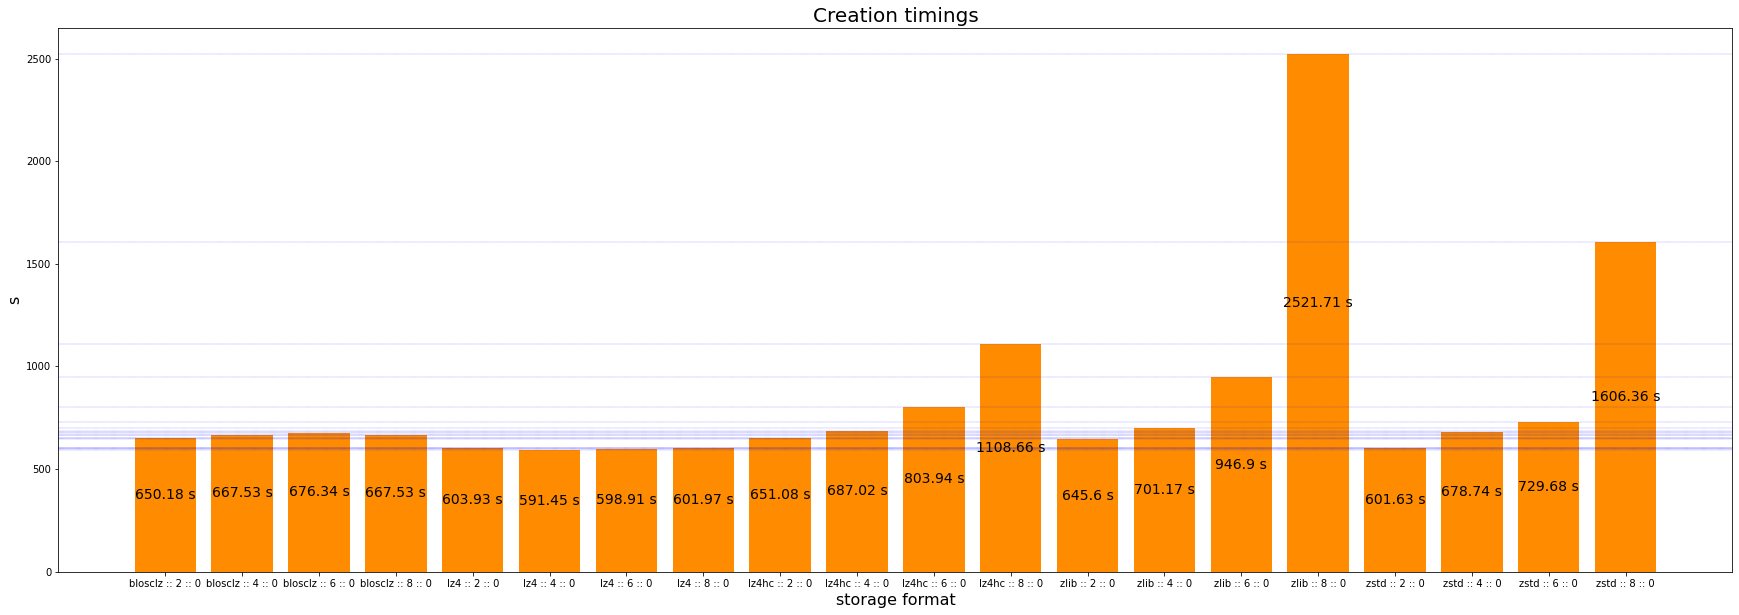

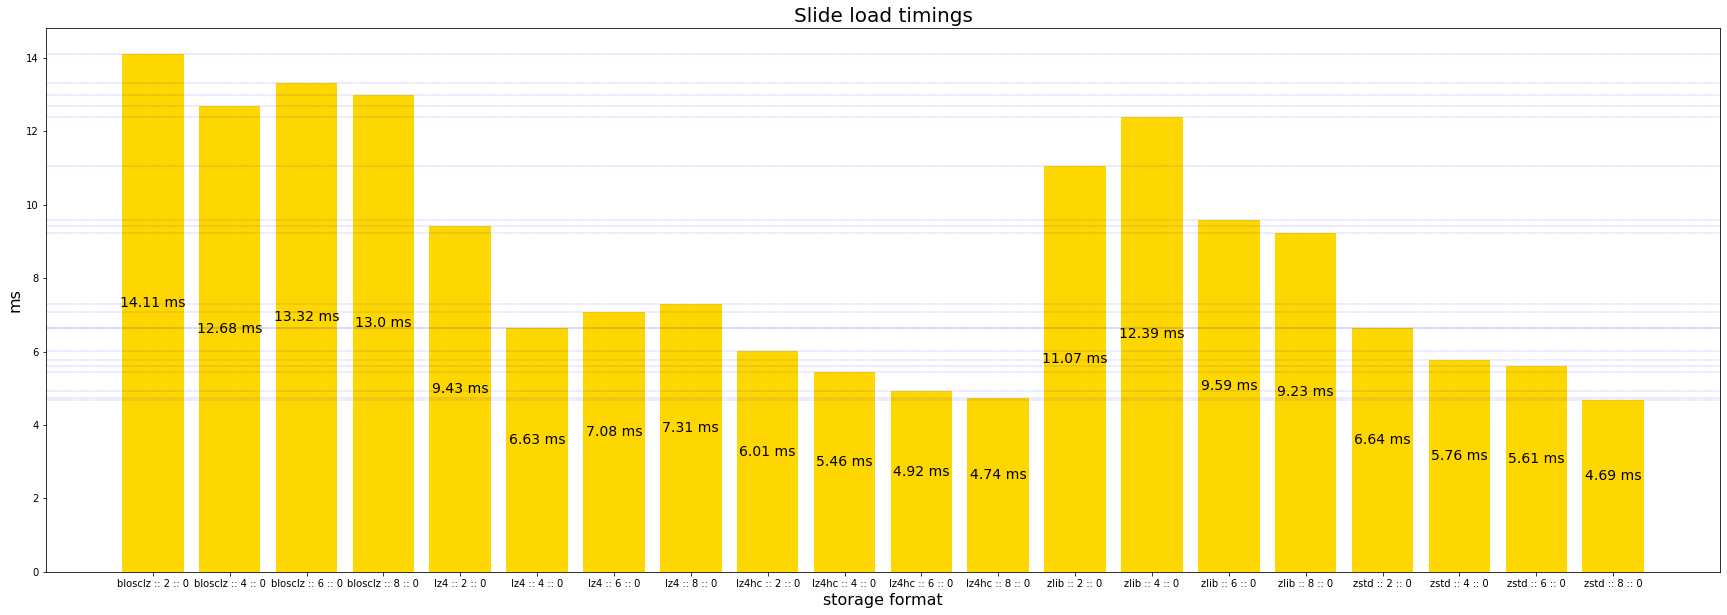

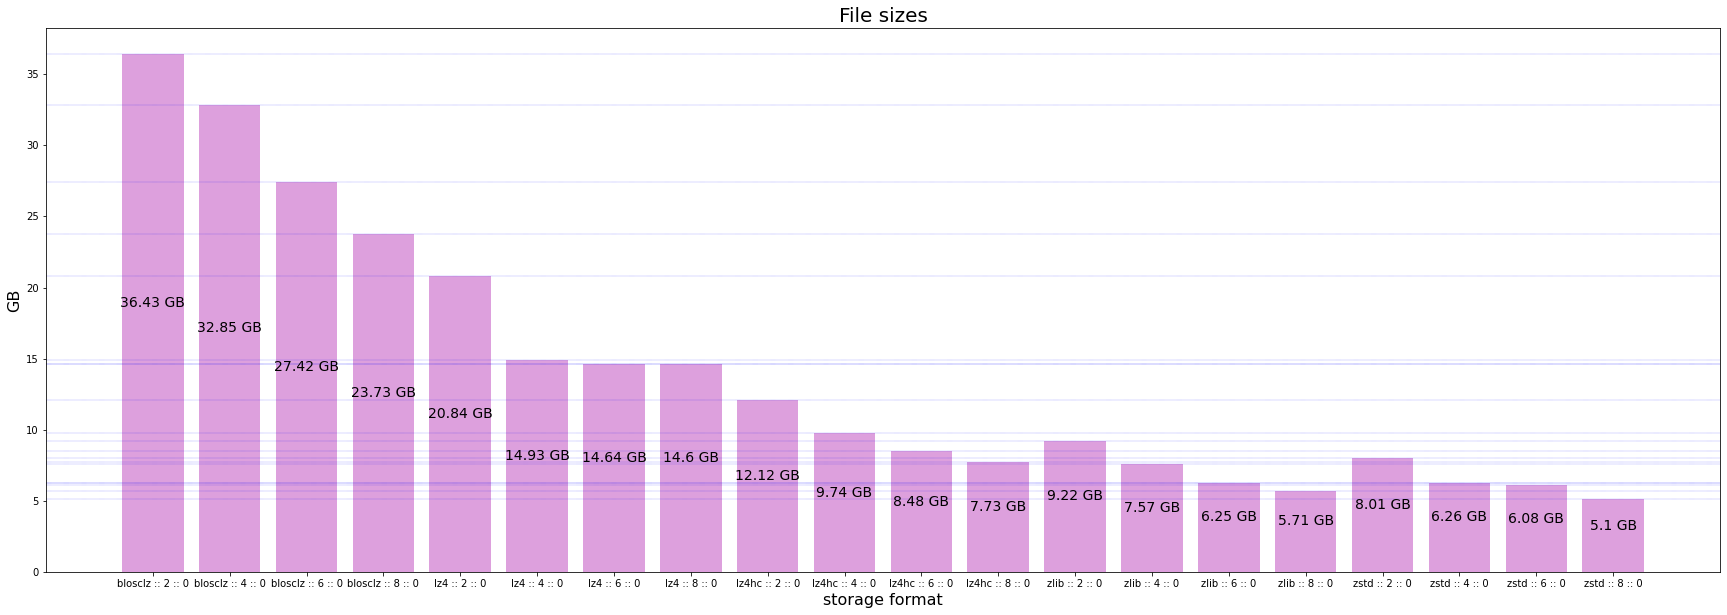

In [5]:
creation_timings = {key : value['creation time'] for key, value in info_dict.items()}
plot_chart(creation_timings, unit='s', title='Creation timings')

slide_timings = {key : value['slide time'] for key, value in info_dict.items()}
plot_chart(slide_timings, unit='ms', title='Slide load timings')

sizes = {key : value['size'] for key, value in info_dict.items()}
plot_chart(sizes, unit='GB', title='File sizes')

# Quantized

In [ ]:
N = 300
info_dict = {}

for cname in blosc.cnames:
    for clevel in [2, 4, 6, 8]:
        for shuffle in [0]:
            key = f'{cname} :: {clevel} :: {shuffle}'
            info_ = {}
            
            # Creation time
            start = perf_counter()
            geometry_blosc = geometry_sgy.convert_to_blosc(quantize=True,
                                                           clevel=clevel,
                                                           cname=cname,
                                                           shuffle=shuffle)
            info_['creation time'] = perf_counter() - start
            
            # Slide loading time
            start = perf_counter()
            for _ in range(N):
                axis = np.random.randint(3)
                loc = np.random.randint(geometry_blosc.cube_shape[axis])
                slide = geometry_blosc.load_slide(loc, axis)
            info_['slide time'] = 1000 * (perf_counter() - start) / N
            
            # File size
            info_['size'] = geometry_blosc.file_size
            
            # Progress
            print(key)
            print(f'Conversion time:      {info_["creation time"]:>7.3f} s')
            print(f'File size:            {info_["size"]:4.3f} GB')
            print(f'Slide loading time:   {info_["slide time"]:>7.3f} ms\n')
            
            info_dict[key] = info_

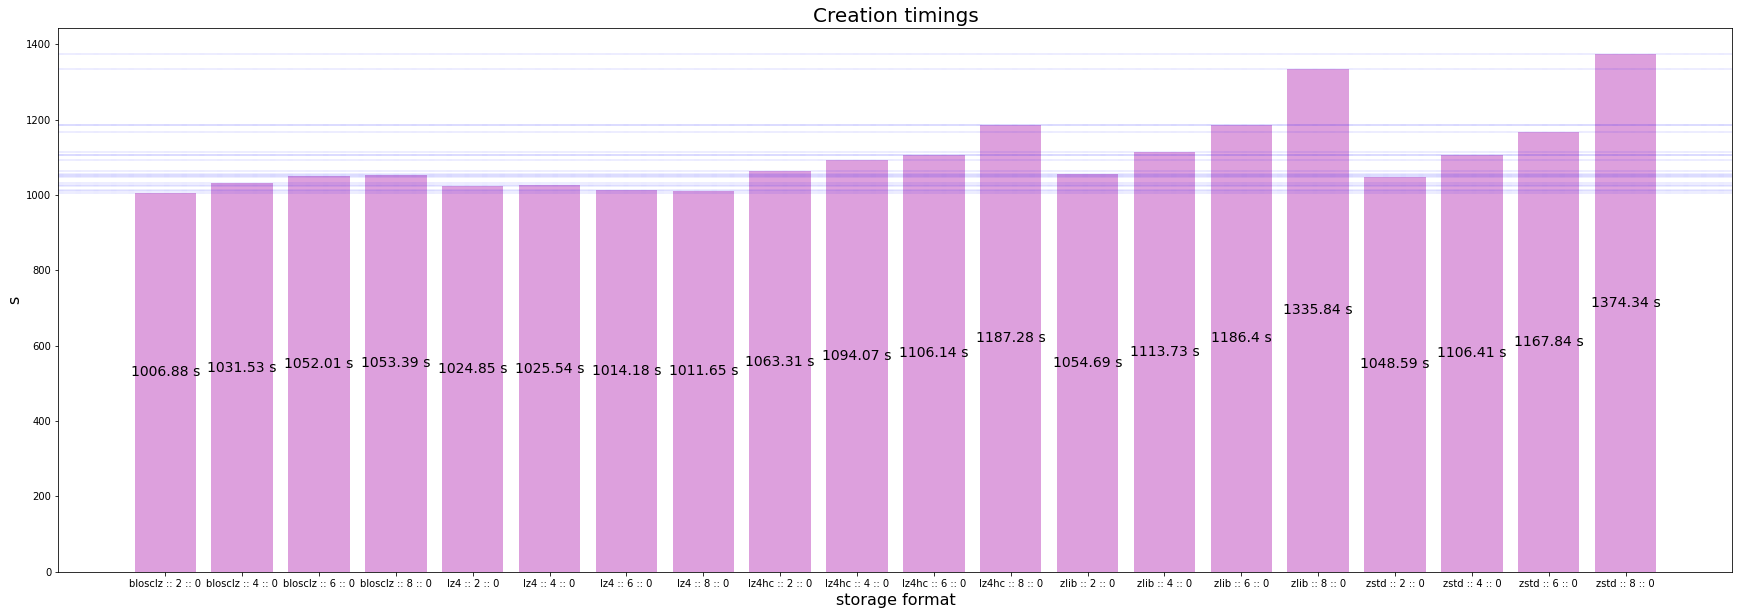

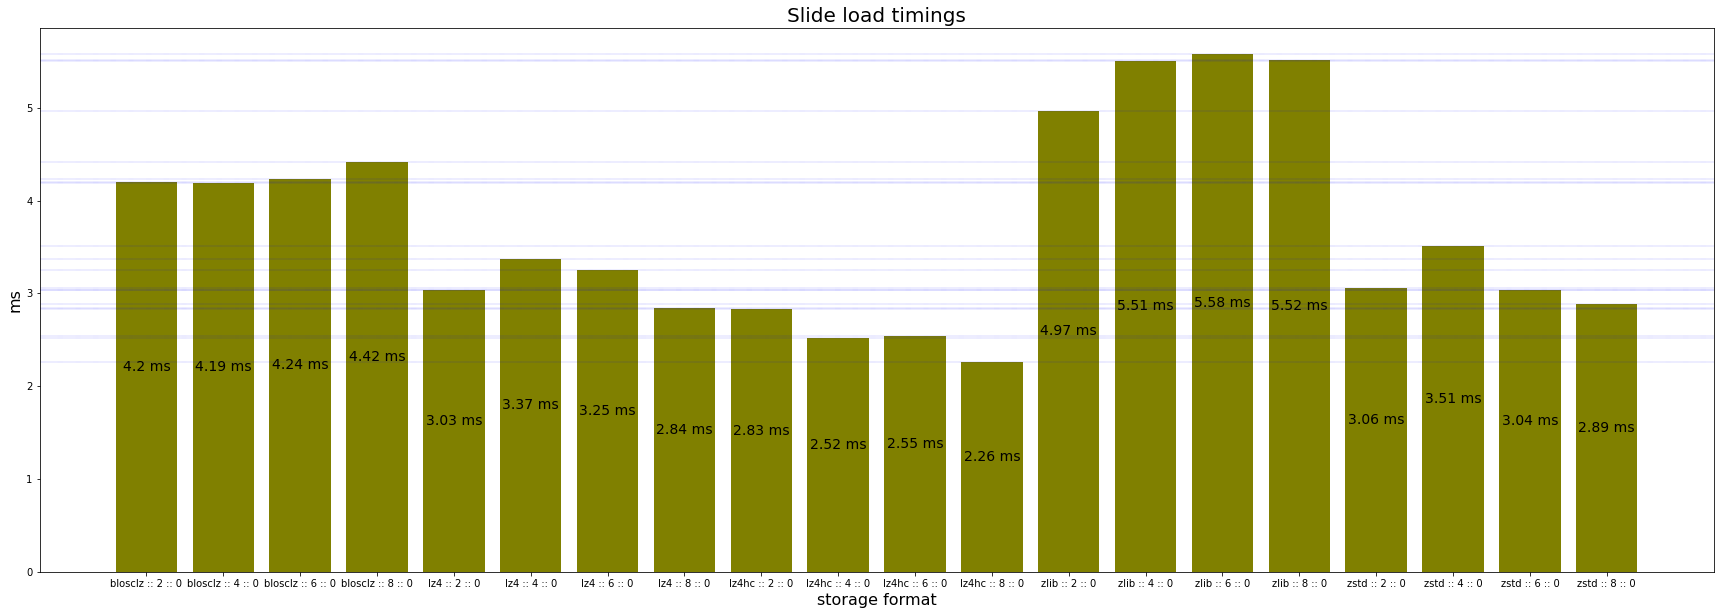

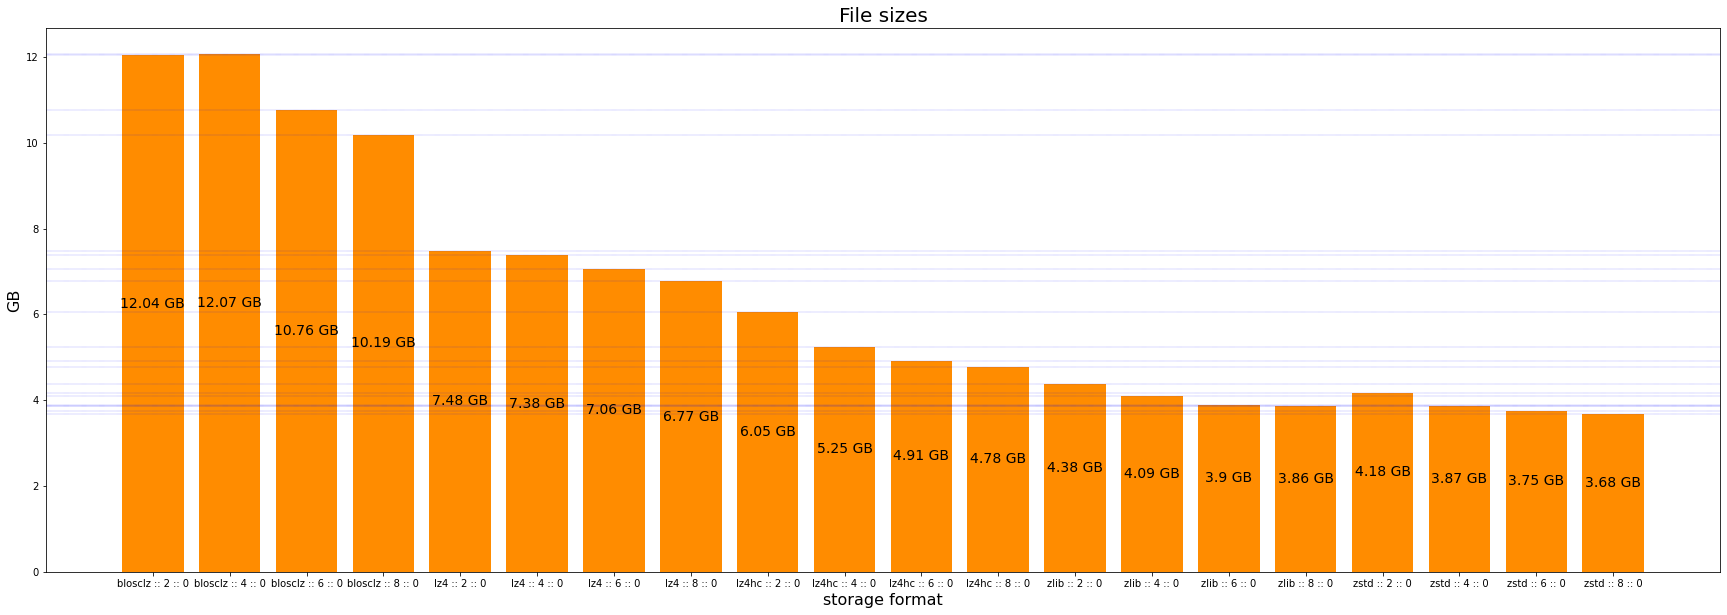

In [9]:
creation_timings = {key : value['creation time'] for key, value in info_dict.items()}
plot_chart(creation_timings, unit='s', title='Creation timings')

slide_timings = {key : value['slide time'] for key, value in info_dict.items()}
plot_chart(slide_timings, unit='ms', title='Slide load timings')

sizes = {key : value['size'] for key, value in info_dict.items()}
plot_chart(sizes, unit='GB', title='File sizes')